In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime, date
from fitter import Fitter, get_common_distributions, get_distributions
from scipy.stats import lognorm, norm, triang, genhyperbolic, burr12
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

start = date(1950,1,1)
end = datetime.today()

fred_series = {'yield02':  'WGS2YR',
               'yield30':  'WGS30YR'}


df = web.DataReader(fred_series.values(), 'fred', start, end)
df.columns = fred_series.keys()
df.index.name = 'date'
df.dropna(inplace=True)
spreadName = "spread" + df.columns[1][5:] + "_" + df.columns[0][5:]
df[spreadName] = df[df.columns[1]] - df[df.columns[0]]
df

,yield02,yield30,spread30_02
date,,,
1977-02-18,6.03,7.70,1.67
1977-02-25,6.14,7.80,1.66
1977-03-04,6.11,7.81,1.70
1977-03-11,6.12,7.82,1.70
1977-03-18,6.08,7.78,1.70
...,...,...,...
2022-08-12,3.24,3.06,-0.18
2022-08-19,3.24,3.14,-0.10
2022-08-26,3.34,3.26,-0.08


In [2]:
adf_results = ['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest']
result=adfuller(df[spreadName])
dict(zip(adf_results, result))

{'adf': -2.60000573727327,
 'pvalue': 0.09299608166670248,
 'usedlag': 22,
 'nobs': 2355,
 'criticalvalues': {'1%': -3.4331298055777806,
  '5%': -2.862768070104647,
  '10%': -2.567423754896525},
 'icbest': -4171.175152135478}

The fact that ```pvalue``` is above 0.05 indicates lack of stationarity.

In [3]:
sprd_chg = df[spreadName].diff()
sprd_chg.dropna(inplace=True)
sprd_chg

date
1977-02-25   -1.000000e-02
1977-03-04    4.000000e-02
1977-03-11    8.881784e-16
1977-03-18    0.000000e+00
1977-03-25    1.000000e-02
                  ...     
2022-08-12   -9.000000e-02
2022-08-19    8.000000e-02
2022-08-26    2.000000e-02
2022-09-02   -8.000000e-02
2022-09-09    1.200000e-01
Freq: W-FRI, Name: spread30_02, Length: 2377, dtype: float64

In [4]:
result=adfuller(sprd_chg)
dict(zip(adf_results, result))

{'adf': -12.980385381844615,
 'pvalue': 2.952166885836307e-24,
 'usedlag': 17,
 'nobs': 2359,
 'criticalvalues': {'1%': -3.433125086901646,
  '5%': -2.8627659864448662,
  '10%': -2.5674226455102995},
 'icbest': -4164.87769796905}

```pvalue``` is now down below 0.05 and ```sprd_chg``` is considered stationary.

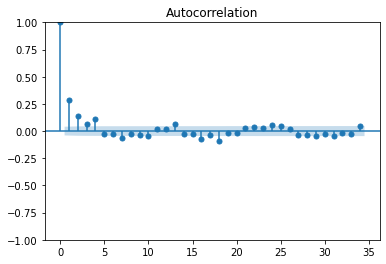

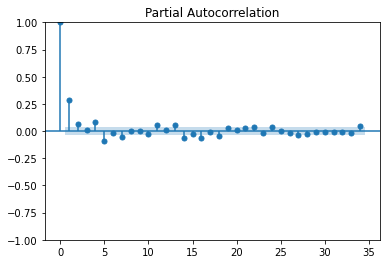

In [5]:
fig1=plot_acf(sprd_chg)
fig2=plot_pacf(sprd_chg, method='ywm')

In [10]:
mod = sm.tsa.ARIMA(df[spreadName], order = (1,1,4))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:            spread30_02   No. Observations:                 2378
Model:                 ARIMA(1, 1, 4)   Log Likelihood                2110.703
Date:                Fri, 16 Sep 2022   AIC                          -4209.406
Time:                        02:53:28   BIC                          -4174.764
Sample:                    02-18-1977   HQIC                         -4196.797
                         - 09-09-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1327      0.073     -1.813      0.070      -0.276       0.011
ma.L1          0.4004      0.072      5.543      0.000       0.259       0.542
ma.L2          0.1598      0.025      6.460      0.0

<AxesSubplot:ylabel='Density'>

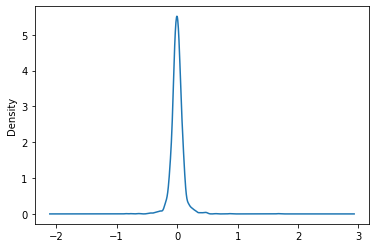

In [13]:
res.resid.plot(kind='kde')

In [4]:
sprd_chg.describe()

count    11387.000000
mean        -0.000148
std          0.055121
min         -0.480000
25%         -0.030000
50%          0.000000
75%          0.020000
max          0.500000
Name: spread30_02, dtype: float64

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
burr12,52.95362,1209.411437,-61120.066266,inf,0.086158,5.448607e-74


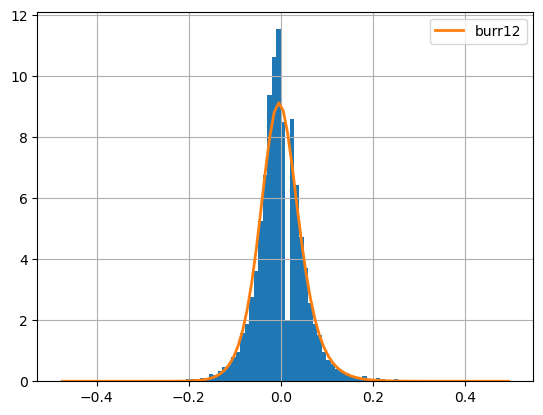

In [5]:
f = Fitter(sprd_chg,
          distributions='burr12')
f.fit()
f.summary()

In [6]:
best = f.get_best(method = 'sumsquare_error')
best_distro = list(best.keys())[0]
best_distro

'burr12'

In [7]:
best_parms  = best[best_distro]
best_parms

{'c': 26.50152447274285,
 'd': 1.012725983227611,
 'loc': -0.7320235203328298,
 'scale': 0.7301564483444316}

In [8]:
randos = burr12.rvs(**best_parms,size=1000)

In [9]:
randos

array([-3.85960247e-02, -3.11204991e-02,  2.32744736e-03, -7.98120979e-02,
       -1.71861398e-02,  2.74562452e-02, -1.80722990e-02,  3.54025878e-02,
        2.81577261e-02,  7.85001037e-02,  4.40365416e-02,  3.56917264e-02,
       -4.61774670e-03, -4.12803902e-02, -3.49413896e-03,  1.18572620e-02,
        2.50915026e-02,  3.83417669e-02,  7.43942005e-03,  2.86682987e-02,
       -4.18286070e-03, -2.65017154e-02,  2.61848842e-02,  4.13773978e-02,
        1.48470341e-02, -7.37906649e-03,  9.60891675e-03, -3.27396135e-02,
        1.02606871e-01, -4.16076906e-02, -1.25678767e-02,  3.75405476e-02,
       -5.75591947e-03,  5.99750888e-03,  3.85539626e-02, -1.10980786e-02,
        9.36484296e-02, -6.78204729e-02, -4.02817542e-02,  1.01504865e-01,
        7.16201207e-02,  3.26581544e-02,  4.65011743e-02,  1.42175921e-02,
       -1.96984746e-02,  1.11037168e-03,  1.77398845e-02,  5.87994755e-02,
       -3.81957008e-02,  1.68805383e-01, -5.18018470e-02,  8.17469886e-02,
        3.17266403e-02,  

In [10]:
burr12.rvs(**best_parms)

-0.03375552569831486

In [11]:
np.percentile(randos, 5)

-0.07995352126581994

In [12]:
np.percentile(randos, 95)

0.09365102527198466